### Step1. 키워드 추출
#### 텍스트 데이터 전처리

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("combined_korean_onlycomment0.csv", encoding='utf-8')
df['text'].head()

0                                         3억전세도 세금받야야지
1                         외국인 25%이고 내국인 3억 ㅎ ㅎ ㅎ 형평성 ?
2                           세금한번내본적없는년들이 부자들세금은내는게당연하냐
3    10월12일 월요일 현재 시가총액10조원을 넘어가는 기업수는 33개이고 기제부가 3...
4                공매도 세력이 뭐준다냐? 증권사 거래세 엄청 나긋네 도둑넘 새,키들
Name: text, dtype: object

In [3]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [4]:
# ‘text’ 피처에 이를 적용
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
df['text'].head()

0                                          억전세도 세금받야야지
1                              외국인 이고 내국인 억 ㅎ ㅎ ㅎ 형평성 
2                           세금한번내본적없는년들이 부자들세금은내는게당연하냐
3    월일 월요일 현재 시가총액조원을 넘어가는 기업수는 개이고 기제부가 억원이상보유하면 ...
4                  공매도 세력이 뭐준다냐 증권사 거래세 엄청 나긋네 도둑넘 새키들
Name: text, dtype: object

#### konlpy이용한 키워드 추출

In [5]:
from konlpy.tag import Okt
from collections import Counter

# 한국어 약식 불용어사전 예시 파일 (출처 - https://www.ranks.nl/stopwords/korean )
korean_stopwords_path = "korean_stopwords.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    
    # 한글자 키워드 제거
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어 제거
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [6]:
pip install jpype1==0.7.0

You should consider upgrading via the '/Users/hyunjinlee/.pyenv/versions/3.8.2/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
df['nouns'] = df['text'].apply(lambda x: get_nouns(x))
print(df.shape)
df.head()

(14022, 7)


,text,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,nouns
0,억전세도 세금받야야지,NaN,NaN,NaN,NaN,NaN,"[세도, 세금]"
1,외국인 이고 내국인 억 ㅎ ㅎ ㅎ 형평성,NaN,NaN,NaN,NaN,NaN,"[외국인, 형평성]"
2,세금한번내본적없는년들이 부자들세금은내는게당연하냐,NaN,NaN,NaN,NaN,NaN,"[세금, 한번, 본적, 부자, 세금]"
3,월일 월요일 현재 시가총액조원을 넘어가는 기업수는 개이고 기제부가 억원이상보유하면 ...,NaN,NaN,NaN,NaN,NaN,"[월일, 월요일, 현재, 시가총액, 조원, 기업, 부가, 이상보, 유하, 주주, 최..."
4,공매도 세력이 뭐준다냐 증권사 거래세 엄청 나긋네 도둑넘 새키들,NaN,NaN,NaN,NaN,NaN,"[공매도, 세력, 증권사, 거래, 도둑]"


### Step2. 연관 분석을 이용한 키워드 분석
#### 연관 키워드 추출하기

In [8]:
!pip install apriori apyori


You should consider upgrading via the '/Users/hyunjinlee/.pyenv/versions/3.8.2/bin/python3.8 -m pip install --upgrade pip' command.


In [9]:
from apyori import apriori

# 장바구니 형태의 데이터(트랜잭션 데이터) 생성
transactions = [
    ['코로나', '주식'],
    ['코로나', '증권'],
    ['코로나', '2030', '시작']
]

# 연관 분석 수행
results = list(apriori(transactions))
for result in results:
    print(result)

RelationRecord(items=frozenset({'2030'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'2030'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'시작'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'시작'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'주식'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'주식'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'증권'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'증권'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'코로나'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'코로나'}), confidence=1.0, lift=1.0)])
RelationRecord(item

#### 연관 키워드 분석

In [11]:
# 트랜잭션 데이터 추출
transactions = df['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction] # 공백 문자열을 방지합니다.
print(transactions)

[['세도', '세금'], ['외국인', '형평성'], ['세금', '한번', '본적', '부자', '세금'], ['월일', '월요일', '현재', '시가총액', '조원', '기업', '부가', '이상보', '유하', '주주', '최저', '배율', '보유', '주주', '분류', '국말이', '그것', '정부', '공무원', '행정명령', '사용', '도대체'], ['공매도', '세력', '증권사', '거래', '도둑'], ['정부', '최악', '박근혜'], ['대도', '요즘', '억대', '대갈'], ['반대', '밀리', '반발', '고취', '소하', '고참', '다처'], ['불당', '신분', '덕분'], ['주식', '억이', '억이'], ['서민', '서민', '정말', '서민', '투표', '상식', '정책', '제발'], ['대한민국', '수준', '조선시대'], ['정부', '절대로'], ['세금', '는걸', '사상', '뿌리', '개탄'], ['국민', '원주', '생색', '국민', '고민', '정부'], ['개미', '세금', '생각', '만하', '쓰레기', '부동산', '주식', '세금', '그것', '가족', '합산', '공산주의', '민주당'], ['거래', '거래', '천만원', '양도', '차익', '세금', '욕심', '제발'], ['연말', '매도', '폭탄', '개미', '피해'], ['개그'], ['이건'], ['세금', '방법', '도둑', '혜택'], ['세금', '연말', '기업', '자금', '조달', '개폭', '오건호', '병신'], ['금융', '소득', '근로', '소득', '형평성', '고려', '면서', '가족', '합산', '방식', '완화', '구멍', '대책'], ['세금', '수가'], ['보도', '필요', '왕건', '쓰레기'], ['좌빨'], ['좌빨', '비트코인', '장난'], ['서민', '알바생', '피빨', '대북', '주기', '일자리', '상황', '보기', '하니'],

In [12]:
# 데이터 프레임 형태로 정리
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,2030,시작,0.333333
1,2030,코로나,0.333333
2,코로나,시작,0.333333
3,코로나,주식,0.333333
4,코로나,증권,0.333333


#### 단어 빈도 추출하기
- 말뭉치 추출

In [13]:
# 말뭉치 추출
content_corpus = "".join(df['text'])
print(content_corpus)

억전세도 세금받야야지외국인 이고 내국인 억 ㅎ ㅎ ㅎ 형평성 세금한번내본적없는년들이 부자들세금은내는게당연하냐월일 월요일 현재 시가총액조원을 넘어가는 기업수는 개이고 기제부가 억원이상보유하면 대주주라고 하는데최저배율이 분의을 보유하면 대주주로 분류가 된다고한국말이 그것도 정부공무원이 행정명령에 사용하는 글이도대체 왜이래공매도 세력이 뭐준다냐 증권사 거래세 엄청 나긋네 도둑넘 새키들미친 진짜적당히 삥뜯어이번 정부 최악이다 진짜 최순실 박근혜가 나은듯차 한대도 요즘 억대인데 누구ㅡ 대갈 통에서 나온 건지반대한다고밀리고반발한다고취소하고참잘한다처음부터좀잘좀하지떠불당찍으신분들 덕분에 신기한거많이보네요 ㅋㅋ주식 하지말라고 왜  억에서 억이지 억이냐고그렇게 서민서민 그러더니 정말 서민만잡네요 ㅡㅡ 이럴려고 투표한거아닌데 상식선에서 정책좀해주세요 제발 에휴대한민국 수준이 딱 조선시대네개같는 정부 절대로 안 찍는다세금 내는걸 당연하듯이 여기는 사상이 너무 뿌리깊게 박혀있다는게 참 개탄스럽다국민에게 만원주며 생색내고 국민을 어떻게 등쳐먹을지 고민만 하는 이번정부 역겹다돌았냐 개미들 세금매길 생각만하네 쓰레기같은놈들 부동산막고 그나마 주식만남았는데 세금 넘게 때가는게 말이되냐 그것도 가족합산으로 공산주의냐민주당이것들 지들 맘대로네거래세를 내잖아 거래세를천만원 이상 양도차익 세금도 하고 이것도 하고 욕심히 너무 지나치네제발 하나만 해라미친ㅎㅎ억 미친다 연말되면 매도폭탄나온다 개미만피해입는다당연한거란다 ㅋㅋ개그하네이건미친짓이네세금 뜯어내는 방법도 다양하네ㅋㅋ 이 도둑넘들은 혜택도 안 주면서 뺐는거는 더럽게 잘해요그 세금 안낼려고 연말에 다 팔아서 기업 자금조달 개폭망하는건데 오건호 병신새낀는 뭐라는겨금융소득과 근로소득의 형평성을 고려한 조치였다 ㅡㅡ면서 가족합산 방식은 완화해 결국 구멍은 또 만들어준거네그러니깐 일하는 척 대책을 세우는 척세금내는게 왜 당연한거임 알 수가 없네 진짜빵 훔친애들 보도할 필요 없고왕건이 꺼내라쓰레기들아수상하다  좌빨놈들  좌빨들이 비트코인 장난질  서민알바

In [14]:
from konlpy.tag import Okt
from collections import Counter

# 명사 키워드 추출
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

# 한글자 키워드 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'주식': 2942, '사람': 1625, '투자': 1444, '코인': 1241, '세금': 1011, '생각': 774, '지금': 651, '도박': 545, '그냥': 522, '진짜': 483, '공부': 439, '화폐': 430, '아나운서': 425, '부동산': 423, '수익': 388, '투기': 385, '정부': 382, '가치': 381, '뉴스': 359, '소리': 343, '보호': 328, '가상': 324, '힐링': 324, '기업': 319, '삼성': 312, '만원': 300, '개미': 295, '나라': 290, '비트코인': 282, '자산': 281, '하나': 276, '보고': 275, '시작': 273, '정도': 272, '우리': 264, '미국': 261, '도지': 257, '문제': 241, '이상': 239, '사기': 238, '검색': 230, '때문': 223, '종목': 222, '장기': 218, '국민': 216, '자기': 216, '여행자': 216, '회사': 211, '무슨': 210, '시장': 209, '누가': 196, '인정': 196, '정보': 189, '세상': 187, '이해': 187, '본인': 186, '세대': 186, '이제': 182, '말씀': 180, '금리': 179, '부자': 178, '은행': 178, '단타': 177, '전자': 177, '거지': 176, '매수': 176, '선생님': 176, '프로': 174, '경제': 173, '한국': 169, '절대': 168, '오픈': 165, '정말': 164, '그게': 161, '방송': 158, '얘기': 155, '기사': 151, '계속': 150, '공매도': 148, '우리나라': 148, '금융': 146, '이번': 144, '이유': 144, '이자': 144, '요즘': 143, '한번': 142, '댓글': 142, '여기': 142, '가지': 14

#### 단어 빈도 점수 추가

In [15]:
# 키워드와 키워드 빈도 점수를 ‘node’, ‘nodesize’ 라는 데이터 프레임의 피처로 생성
node_df = pd.DataFrame(remove_char_counter.items(), columns=['node', 'nodesize'])
node_df = node_df[node_df['nodesize'] >= 50] # 시각화의 편의를 위해 ‘nodesize’ 50 이하는 제거합니다.
node_df.head()

,node,nodesize
1,세금,1011
4,한번,142
6,부자,178
9,현재,96
12,기업,319


### Step3. 시각화 :  연관 키워드 네트워크 시각화
#### 연관 키워드 네트워크 시각화


아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
(env_name) pip install networkx
혹은 아래의 코드로 라이브러리를 설치합니다.
networkx 버전 2.3 이하를 설치하는 경우, 아래 코드를 다음과 같이 바꿔주어야 합니다.


sizes = [G.nodes[node]['nodesize']*25 for node in G] -> sizes = [G.node[node]['nodesize']*25 for node in G]

In [16]:
!pip install networkx

You should consider upgrading via the '/Users/hyunjinlee/.pyenv/versions/3.8.2/bin/python3.8 -m pip install --upgrade pip' command.


In [17]:
node_df['nodesize']

1        1011
4         142
6         178
9          96
12        319
         ... 
4857       53
4874      186
5024       61
5857       76
10469      75
Name: nodesize, Length: 330, dtype: int64

In [25]:
gnodes = G.nodes()
print(len(gnodes))

332


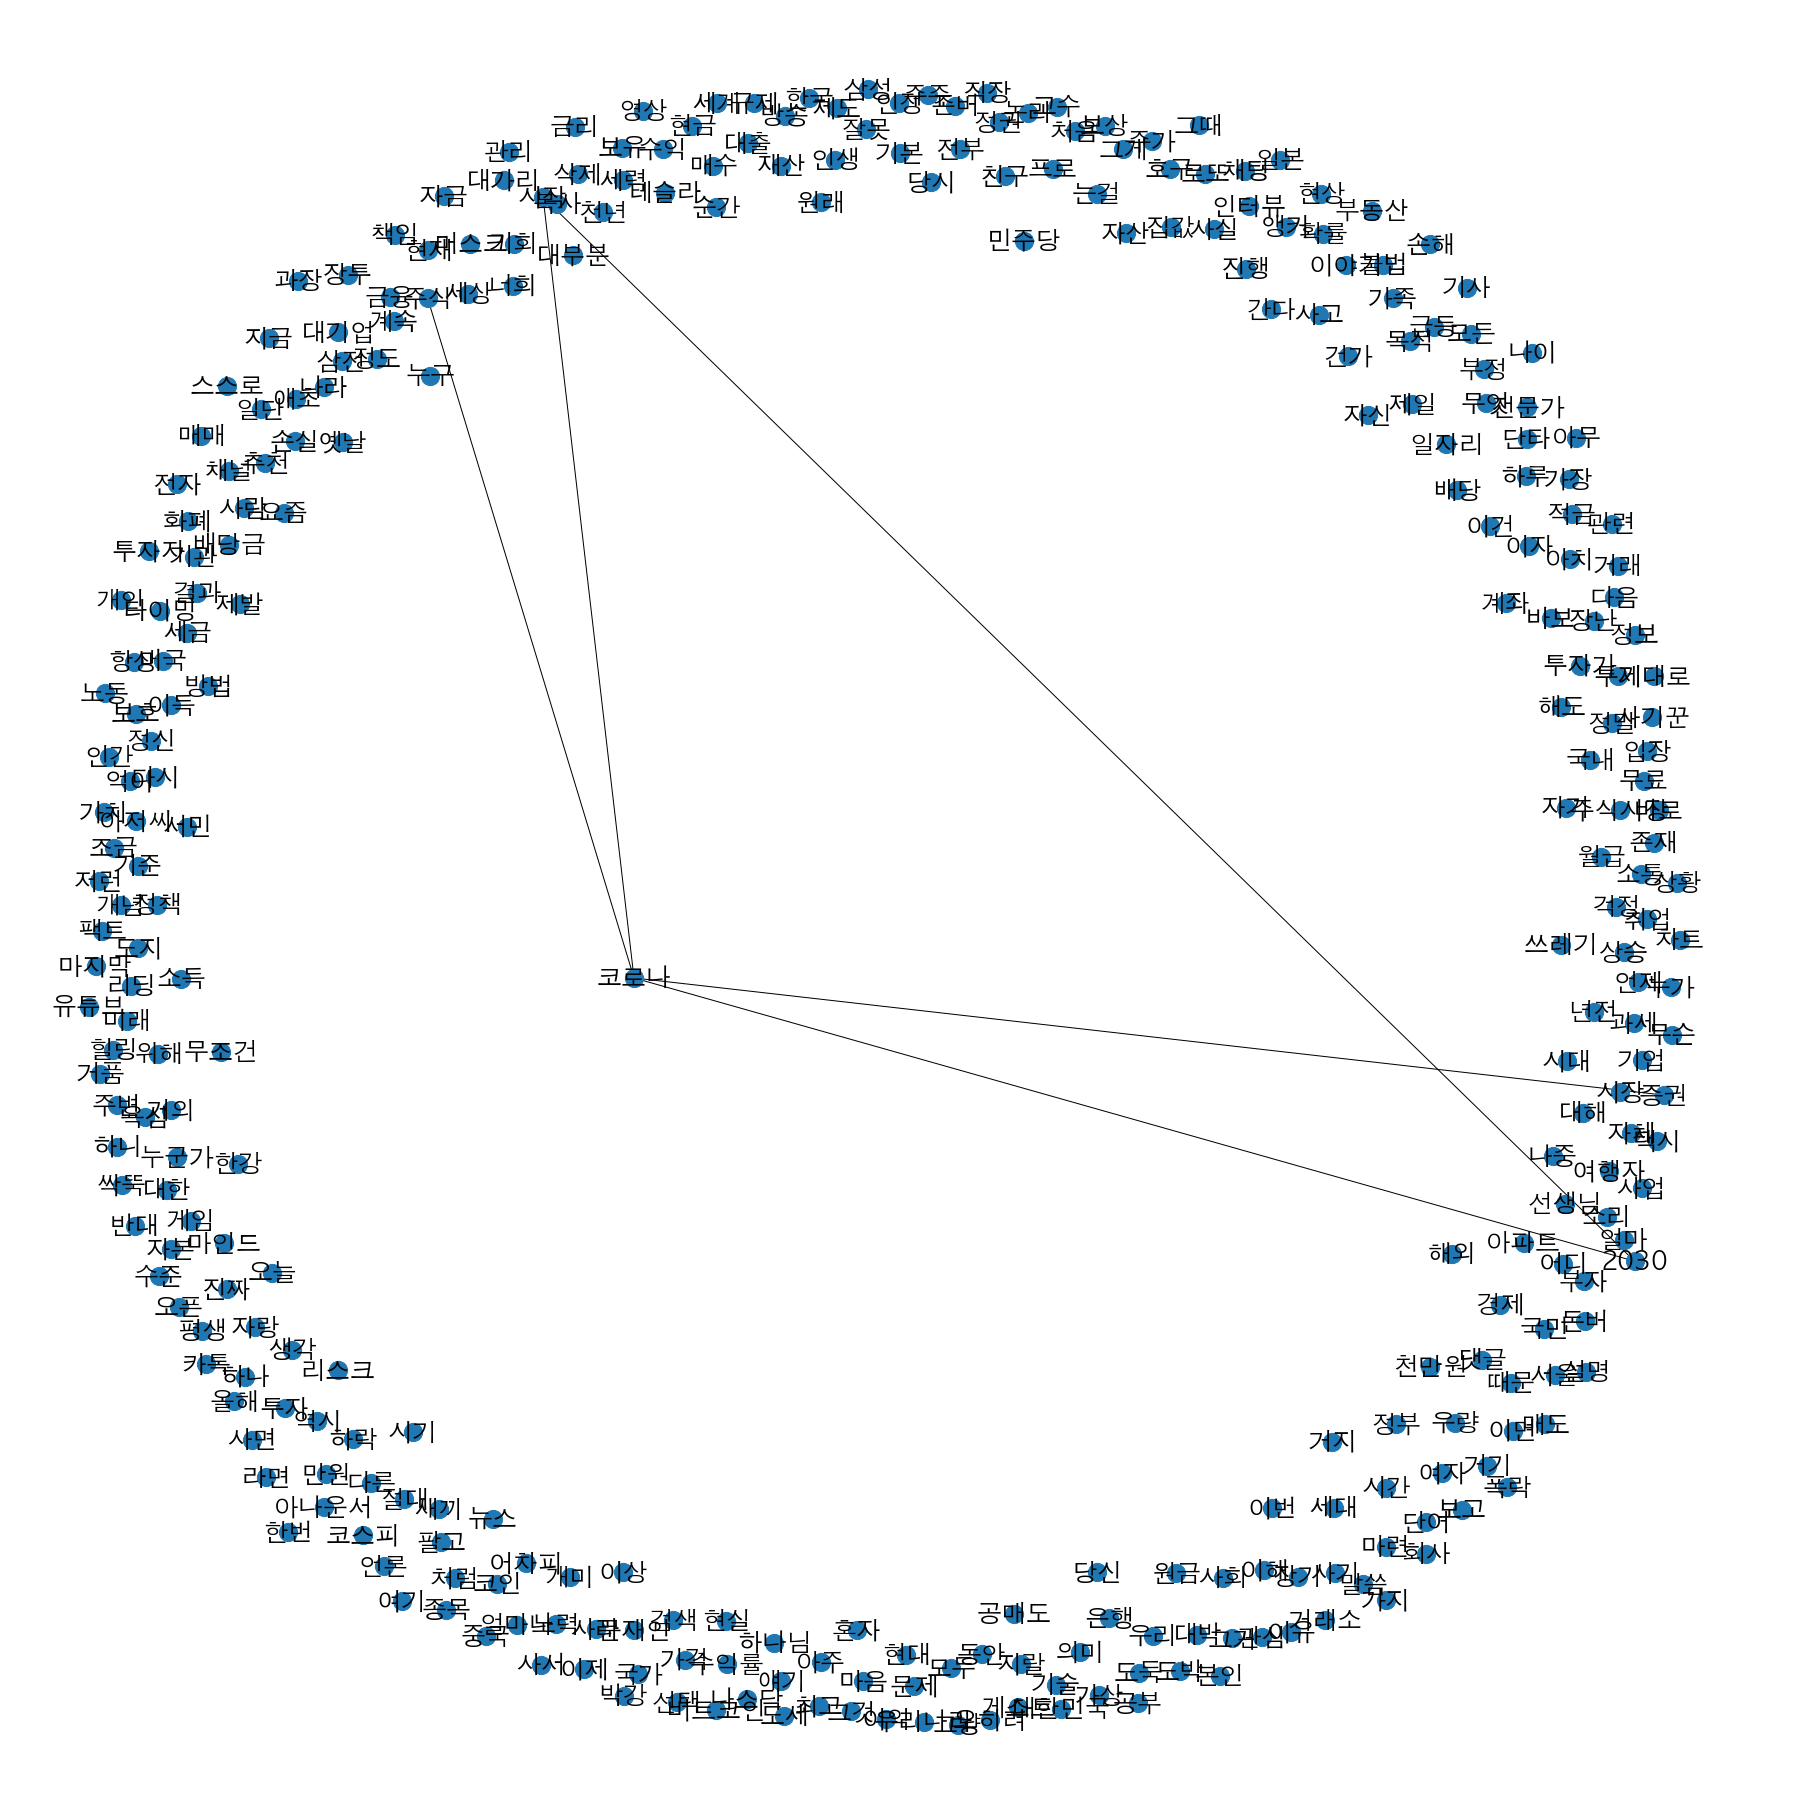

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))

# networkx 그래프 객체 생성
G = nx.Graph()

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’ 역할을 하는 원 생성
for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])
    
# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’ 역할을 하는 선 생성
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    
# 그래프 디자인과 관련된 파라미터 설정
pos = nx.spring_layout(G, k=0.6, iterations=50)
sizes = 332
nx.draw(G, pos=pos, node_size=sizes)
nx.draw_networkx_labels(G, pos=pos, font_family='AppleGothic', font_size=25)

# 그래프 출력
ax = plt.gca()
plt.show()



참고: https://github.com/yoonkt200/python-data-analysis/blob/master/chapter2/02-twitter-text-analysis.ipynb